In [10]:
from machinelearning.mlpipeline import MLPipelines
from machinelearning.featexpl import FeaturesExplanation

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from catboost import CatBoostClassifier

csv_dir = 'data/EPIC_norm_pos.txt'
# csv_dir = 'data/composite_dataset.csv'
label = 'group'

# model = LogisticRegression()

%load_ext autoreload
%autoreload 2

# %matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# dataloader
mlpipe = MLPipelines(label=label, csv_dir=csv_dir)
# mlpipe = MLPipelines(label=label, csv_dir=csv_dir, estimator=CatBoostClassifier())

# mlpipe._encode_labels()
mlpipe.normalize()
mlpipe.feature_selection(method='mrmr', num_features=100, inner_method='chi2')

mlpipe.X=mlpipe.X.fillna(0)

Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}
There is no selected classifier.


In [12]:
# mlpipe.bayesian_search()
# xg = [GradientBoostingClassifier(), LinearDiscriminantAnalysis(),  GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC(),XGBClassifier()]
# xg = [LinearDiscriminantAnalysis(), XGBClassifier(), GradientBoostingClassifier(), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC()]

In [13]:
# mlpipe.X=mlpipe.X.fillna(0)

# logger = logging.getLogger()
# logger.setLevel(logging.CRITICAL)

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Outer fold of 0 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 4 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round: 20% |██▌          | Elapsed Time: 0:01:54 ETA:   0:07:39
Outer fold of 0 round: 20% |██▌          | Elapsed Time: 0:02:25 ETA:   0:09:40
Outer fold of 1 round: 20% |██▌          | Elapsed Time: 0:02:17 ETA:   0:09:10
Outer fold of 1 round: 40% |█████▏       | Elapsed Time: 0:03:59 ETA:   0:05:59
Outer fold of 3 round: 40% |█████▏       | Elapsed Time: 0:03:59 ETA:   0:05:58
Outer fold of 4 round: 20% |██▌          | Elapsed Time: 0:03:37 ETA:   0:14:28
Outer fold of 0 round: 40% |█████▏       | Elapsed Time: 0:04:45 ETA:   0:07:08
Outer fold of 3 round: 60% |███████▊     | Elapsed Time: 0:05:53 ETA:   0:03:55
Outer fold of 1 round: 60% |███████▊    

Finished with 1 round after 0.17 hours.


Outer fold of 3 round: 80% |██████████▍  | Elapsed Time: 0:08:23 ETA:   0:02:05
Outer fold of 3 round:100% |█████████████| Elapsed Time: 0:08:24 Time:  0:08:24


Finished with 4 round after 0.18 hours.


Outer fold of 1 round: 80% |██████████▍  | Elapsed Time: 0:09:29 ETA:   0:02:22
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:09:29 Time:  0:09:29


Finished with 2 round after 0.20 hours.


Outer fold of 4 round: 60% |███████▊     | Elapsed Time: 0:09:40 ETA:   0:06:26
Outer fold of 5 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 4 round: 80% |██████████▍  | Elapsed Time: 0:11:04 ETA:   0:02:46
Outer fold of 4 round:100% |█████████████| Elapsed Time: 0:11:04 Time:  0:11:04


Finished with 5 round after 0.23 hours.


Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 5 round: 20% |██▌          | Elapsed Time: 0:02:16 ETA:   0:09:05
Outer fold of 2 round: 20% |██▌          | Elapsed Time: 0:02:12 ETA:   0:08:49
Outer fold of 5 round: 40% |█████▏       | Elapsed Time: 0:03:58 ETA:   0:05:58
Outer fold of 2 round: 40% |█████▏       | Elapsed Time: 0:04:24 ETA:   0:06:36
Outer fold of 5 round: 60% |███████▊     | Elapsed Time: 0:05:56 ETA:   0:03:57
Outer fold of 2 round: 60% |███████▊     | Elapsed Time: 0:06:02 ETA:   0:04:01
Outer fold of 5 round: 80% |██████████▍  | Elapsed Time: 0:08:03 ETA:   0:02:00
Outer fold of 5 round:100% |█████████████| Elapsed Time: 0:08:03 Time:  0:08:03


Finished with 6 round after 0.18 hours.


Outer fold of 2 round: 80% |██████████▍  | Elapsed Time: 0:08:23 ETA:   0:02:05
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:08:23 Time:  0:08:23


Finished with 3 round after 0.19 hours.
Finished with 11 estimators
No features were selected.


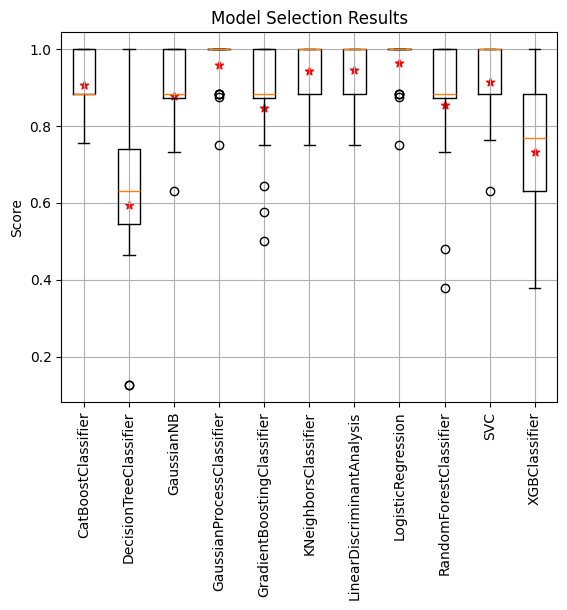

Best trial: 0. Best value: 1: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]

For the LogisticRegression model: 
Best parameters: {'penalty': 'l2', 'C': 2.950311360179394, 'solver_2': 'sag', 'max_iter': 764, 'fit_intercept': False}
Best matthews_corrcoef: 1.0


In [23]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=50,n_trials=50,rounds=6,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=5,inner_splits=3,hist_fit=True,exclude=[LGBMClassifier()],parallel='freely_parallel')#exclude=[LGBMClassifier()])# search_on=[LinearDiscriminantAnalysis(),LogisticRegression()])#exclude=[LGBMClassifier()])

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 4 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 0 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 5 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 0 round: 20% |██▌          | Elapsed Time: 0:01:39 ETA:   0:06:37
Outer fold of 4 round: 20% |██▌          | Elapsed Time: 0:01:46 ETA:   0:07:04
Outer fold of 3 round: 20% |██▌          | Elapsed Time: 0:01:32 ETA:   0:06:11
Outer fold of 1 round: 20% |██▌          | Elapsed Time: 0:02:28 ETA:   0:09:55
Outer fold of 2 round: 20% |██▌          | Elapsed Time: 0:01:54 ETA:   0:07:38
Outer fold of 3 round: 40% |█████▏       | Elapsed Time: 0:02:59 ETA:   0:04:28
Outer fold of 5 round: 20% |██▌         

Finished with 4 round after 0.17 hours.


Outer fold of 0 round: 80% |██████████▍  | Elapsed Time: 0:08:18 ETA:   0:02:04
Outer fold of 0 round:100% |█████████████| Elapsed Time: 0:08:18 Time:  0:08:18


Finished with 1 round after 0.18 hours.


Outer fold of 4 round: 80% |██████████▍  | Elapsed Time: 0:08:46 ETA:   0:02:11
Outer fold of 4 round:100% |█████████████| Elapsed Time: 0:08:46 Time:  0:08:46


Finished with 5 round after 0.18 hours.


Outer fold of 2 round: 80% |██████████▍  | Elapsed Time: 0:08:47 ETA:   0:02:11
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:08:47 Time:  0:08:47


Finished with 3 round after 0.19 hours.


Outer fold of 5 round: 60% |███████▊     | Elapsed Time: 0:08:41 ETA:   0:05:47
Outer fold of 1 round: 80% |██████████▍  | Elapsed Time: 0:10:29 ETA:   0:02:37
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:10:29 Time:  0:10:29


Finished with 2 round after 0.21 hours.


Outer fold of 5 round: 80% |██████████▍  | Elapsed Time: 0:10:27 ETA:   0:02:36
Outer fold of 5 round:100% |█████████████| Elapsed Time: 0:10:27 Time:  0:10:27


Finished with 6 round after 0.23 hours.
Finished with 11 estimators
No features were selected.


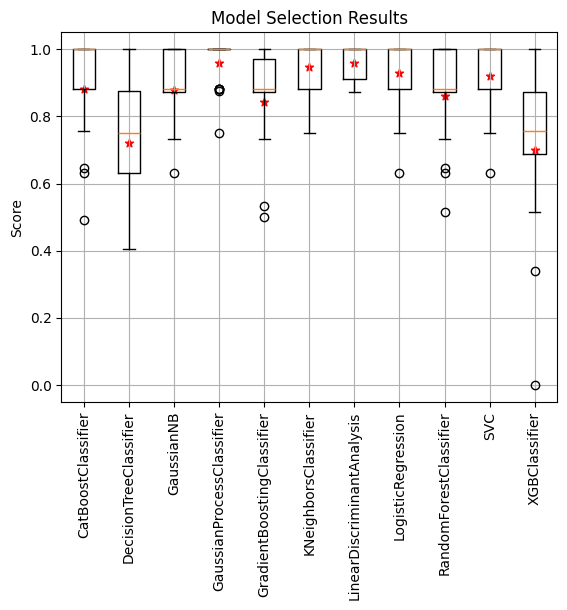

Best trial: 0. Best value: 0.976383: 100%|██████████| 50/50 [00:01<00:00, 33.14it/s]

For the GaussianProcessClassifier model: 
Best parameters: {'optimizer': None, 'max_iter_predict': 69, 'warm_start': False}
Best matthews_corrcoef: 0.9763834207376394


In [24]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=50,n_trials=50,rounds=6,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=5,inner_splits=3,hist_fit=True,exclude=[LGBMClassifier()],parallel='fully_parallel')#exclude=[LGBMClassifier()])# search_on=[LinearDiscriminantAnalysis(),LogisticRegression()])#exclude=[LGBMClassifier()])

In [6]:
stop

NameError: name 'stop' is not defined

100%|██████████| 10/10 [00:00<00:00, 14573.68it/s]


<IPython.core.display.HTML object>


Processing outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Processing outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.HTML object>


Processing outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Processing outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.HTML object>


Processing outer fold: 100%|██████████| 5/5 [14:14<00:00, 170.97s/it]


Finished with 10 round after 0.24 hours.


Processing outer fold: 100%|██████████| 5/5 [14:29<00:00, 173.83s/it]


Finished with 7 round after 0.24 hours.


Processing outer fold: 100%|██████████| 5/5 [15:13<00:00, 182.69s/it]


Finished with 3 round after 0.25 hours.


Processing outer fold: 100%|██████████| 5/5 [15:54<00:00, 190.84s/it]


Finished with 6 round after 0.27 hours.


Processing outer fold: 100%|██████████| 5/5 [16:25<00:00, 197.17s/it]


Finished with 2 round after 0.27 hours.


Processing outer fold: 100%|██████████| 5/5 [16:26<00:00, 197.37s/it]


Finished with 5 round after 0.27 hours.


Processing outer fold: 100%|██████████| 5/5 [16:38<00:00, 199.62s/it]


Finished with 8 round after 0.28 hours.


Processing outer fold: 100%|██████████| 5/5 [16:37<00:00, 199.56s/it]


Finished with 4 round after 0.28 hours.


Processing outer fold: 100%|██████████| 5/5 [16:51<00:00, 202.30s/it]


Finished with 9 round after 0.28 hours.
Finished with 1 round after 0.29 hours.
Finished with 11 estimators
No features were selected.


Processing outer fold: 100%|██████████| 5/5 [17:08<00:00, 205.70s/it]


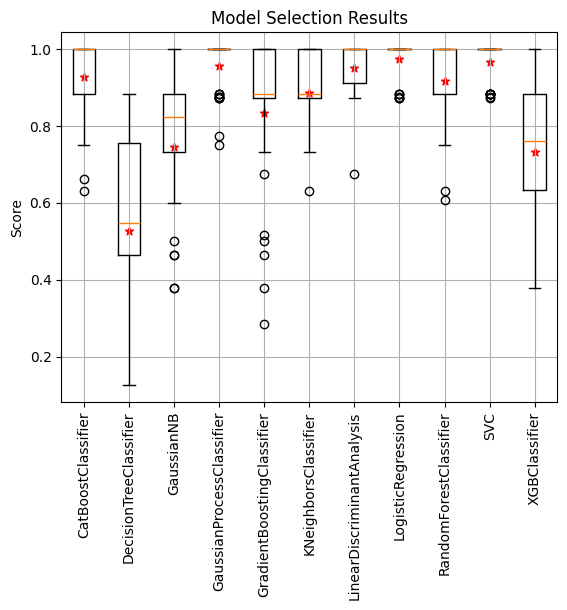

  0%|          | 0/50 [00:00<?, ?it/s]

For the LogisticRegression model: 
Best parameters: {'penalty': 'l2', 'C': 6.155265932441569, 'solver_2': 'sag', 'max_iter': 253, 'fit_intercept': True}
Best matthews_corrcoef: 1.0


In [ ]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=50,n_trials=50,rounds=10,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=5,inner_splits=3,hist_fit=True,exclude=[LGBMClassifier()],parallel='fully_parallel')#exclude=[LGBMClassifier()])# search_on=[LinearDiscriminantAnalysis(),LogisticRegression()])#exclude=[LGBMClassifier()])

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=100,n_trials=50,rounds=10,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=5,inner_splits=5,hist_fit=True,exclude=[LGBMClassifier()],parallel='thread_per_round')#exclude=[LGBMClassifier()])# search_on=[LinearDiscriminantAnalysis(),LogisticRegression()])#exclude=[LGBMClassifier()])

Processing outer fold: 100%|██████████| 5/5 [3:33:49<00:00, 2565.84s/it]  


Finished with 6 round after 3.56 hours.


Processing outer fold: 100%|██████████| 5/5 [4:10:25<00:00, 3005.06s/it]  


Finished with 8 round after 4.17 hours.


Processing outer fold: 100%|██████████| 5/5 [4:27:05<00:00, 3205.10s/it]t]


Finished with 9 round after 4.45 hours.


Processing outer fold: 100%|██████████| 5/5 [4:28:07<00:00, 3217.49s/it]t]


Finished with 4 round after 4.47 hours.


Processing outer fold: 100%|██████████| 5/5 [4:38:51<00:00, 3346.37s/it]


Finished with 3 round after 4.65 hours.


Processing outer fold: 100%|██████████| 5/5 [4:44:18<00:00, 3411.64s/it]  


Finished with 2 round after 4.74 hours.


Processing outer fold: 100%|██████████| 5/5 [4:52:51<00:00, 3514.27s/it]


Finished with 10 round after 4.88 hours.


Processing outer fold: 100%|██████████| 5/5 [4:59:01<00:00, 3588.36s/it]  


Finished with 7 round after 4.98 hours.


Processing outer fold: 100%|██████████| 5/5 [4:59:50<00:00, 3598.15s/it]  


Finished with 1 round after 5.00 hours.


Processing outer fold: 100%|██████████| 5/5 [5:53:26<00:00, 4241.30s/it]  


Finished with 5 round after 5.89 hours.


Processing trials: 100%|██████████| 10/10 [5:53:26<00:00, 2120.66s/it]   


Finished with 11 estimators
No features were selected.


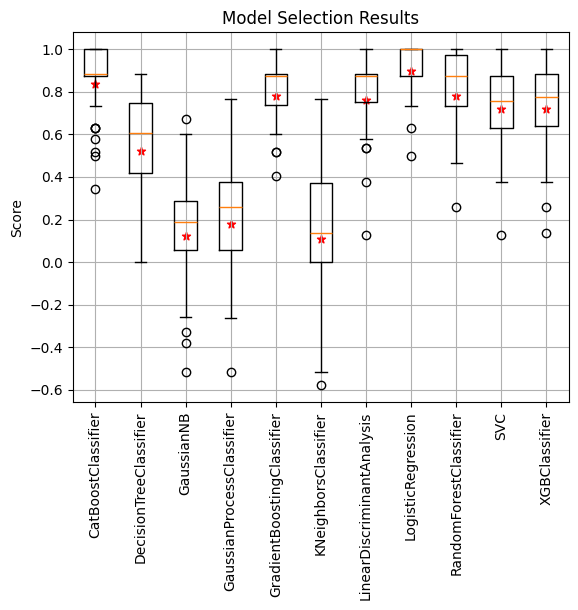

  0%|          | 0/50 [00:00<?, ?it/s]

/home/spyros/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.37157e-21): result may not be accurate.
  warnings.warn(
/home/spyros/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features o

For the LogisticRegression model: 
Best parameters: {'penalty': 'l1', 'C': 8.209518333151777, 'solver_1': 'liblinear', 'max_iter': 132, 'fit_intercept': False}
Best matthews_corrcoef: 0.9273411536640725


In [ ]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=100,n_trials=50,rounds=10,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=5,inner_splits=5,hist_fit=True,exclude=[LGBMClassifier()],parallel='freely_parallel')#exclude=[LGBMClassifier()])# search_on=[LinearDiscriminantAnalysis(),LogisticRegression()])#exclude=[LGBMClassifier()])


In [ ]:
df

,Estimator,Classifier,Scores,Max,Std,Median,Evaluated,Selected_Features,Numbers_of_Features,Way_of_Selection
0,LinearDiscriminantAnalysis,LinearDiscriminantAnalysis_mrmr_10,"[0.8563488385776753, 1.0, 1.0, 0.6923076923076...",1.00000,0.116446,1.000000,0.901487,"[[942.9824_0.57, 370.0949_33.34, 393.3454_25.6...",10,mrmr
1,LinearDiscriminantAnalysis,LinearDiscriminantAnalysis_mrmr_100,"[0.6324555320336759, 0.9258200997725515, 0.617...",0.92582,0.135337,0.666552,0.685839,"[[942.9824_0.57, 370.0949_33.34, 393.3454_25.6...",100,mrmr
2,LinearDiscriminantAnalysis,LinearDiscriminantAnalysis_mrmr_50,"[0.7905694150420949, 1.0, 0.5, 0.6172133998483...",1.00000,0.163859,0.818362,0.733910,"[[942.9824_0.57, 370.0949_33.34, 393.3454_25.6...",50,mrmr
3,LogisticRegression,LogisticRegression_mrmr_10,"[0.8563488385776753, 1.0, 0.8563488385776753, ...",1.00000,0.082632,0.891084,0.885146,"[[942.9824_0.57, 370.0949_33.34, 393.3454_25.6...",10,mrmr
4,LogisticRegression,LogisticRegression_mrmr_100,"[0.7006490497453707, 0.9258200997725515, 0.925...",1.00000,0.118193,0.848668,0.813771,"[[942.9824_0.57, 370.0949_33.34, 393.3454_25.6...",100,mrmr
5,LogisticRegression,LogisticRegression_mrmr_50,"[0.7006490497453707, 0.8563488385776753, 0.077...",0.92582,0.286371,0.813933,0.640815,"[[942.9824_0.57, 370.0949_33.34, 393.3454_25.6...",50,mrmr


In [ ]:
self, X_train_selected, X_test_selected, y_train, y_test, clfs=None, feat_num=None, feature_selection_type='mrmr',
percentile=None,
feature_selection_method='chi2', optimizer='grid_search', inner_scoring='matthews_corrcoef', inner_cv=5, n_jobs=-1, 
verbose=0, n_iter=25, n_trials=100, best_params_list=None, nested_scores=None, outer_scorer='matthews_corrcoef'


LogisticRegression()

In [ ]:
import cProfile
import pstats

# Convert the function call into a string
profile_command = "mlpipe.nested_cross_validation(optimizer='bayesian_search')"

# Run the profiling
cProfile.run(profile_command, 'profile_stats')

# Load the stats
p = pstats.Stats('profile_stats')

# Sort and print the stats
p.sort_stats('cumulative').print_stats(10)


Performing nested cross-validation for LogisticRegression...
Trial 1 out of 2
Outer fold 1 out of 5
Outer fold 2 out of 5
Outer fold 3 out of 5
Outer fold 4 out of 5
Outer fold 5 out of 5
Trial 2 out of 2
Outer fold 1 out of 5
Outer fold 2 out of 5
Outer fold 3 out of 5
Outer fold 4 out of 5
Outer fold 5 out of 5
Mon Feb 12 15:10:22 2024    profile_stats

         308424 function calls (303678 primitive calls) in 36.307 seconds

   Ordered by: cumulative time
   List reduced from 970 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   36.307   36.307 {built-in method builtins.exec}
        1    0.000    0.000   36.307   36.307 <string>:1(<module>)
        1    0.001    0.001   36.307   36.307 /home/spyros/Desktop/AI4META/machinelearning/mlpipeline.py:143(nested_cross_validation)
       10    0.002    0.000   36.295    3.630 /home/spyros/Desktop/AI4META/machinelearning/mlpipeline.py:115(inner_loop)
       1

In [ ]:
print(df.Best_Params[0])
print(df.Scores[0])

[{'n_estimators': 120, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'bootstrap': True}
 {'n_estimators': 18, 'criterion': 'entropy', 'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 5, 'bootstrap': False}
 {'n_estimators': 134, 'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 6, 'bootstrap': False}
 {'n_estimators': 169, 'criterion': 'entropy', 'max_depth': 37, 'min_samples_leaf': 5, 'min_samples_split': 4, 'bootstrap': True}
 {'n_estimators': 82, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 10, 'bootstrap': True}
 {'n_estimators': 11, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 9, 'bootstrap': True}
 {'n_estimators': 41, 'criterion': 'entropy', 'max_depth': 36, 'min_samples_leaf': 2, 'min_samples_split': 2, 'bootstrap': True}
 {'n_estimators': 154, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_sampl

In [ ]:
# import pickle
# filename = 'fitted_10.sav'
# # # pickle.dump(fitted_mod, open(filename, 'wb'))
# fitted_mod = pickle.load(open(filename, 'rb'))

# dataloader
mlpipe = MLPipelines(estimator=model, param_grid={}, label=label, csv_dir=csv_dir)
# mlpipe._encode_labels()
mlpipe.normalize()
mlpipe.feature_selection(method='mrmr', n_features=10, inner_method='chi2')


Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}


100%|██████████| 10/10 [00:00<00:00, 19.15it/s]


In [ ]:
# fitted_mod = XGBClassifier(booster='gbtree').fit(mlpipe.X, mlpipe.y)
# fitted_mod = RandomForestClassifier().fit(mlpipe.X, mlpipe.y)
fitted_mod = LogisticRegression().fit(mlpipe.X, mlpipe.y)
# fitted_mod = DecisionTreeClassifier().fit(mlpipe.X, mlpipe.y)
# fitted_mod = GradientBoostingClassifier().fit(mlpipe.X, mlpipe.y)
# fitted_mod = LinearDiscriminantAnalysis().fit(mlpipe.X, mlpipe.y)
# fitted_mod = GaussianNB().fit(mlpipe.X, mlpipe.y)
# fitted_mod = GaussianProcessClassifier().fit(mlpipe.X, mlpipe.y)
# fitted_mod = SVC().fit(mlpipe.X, mlpipe.y)
# fitted_mod = CatBoostClassifier(verbose=0).fit(mlpipe.X, mlpipe.y)

In [ ]:
fesel = FeaturesExplanation(best_estimator=fitted_mod, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
fesel.calculate_shap_values(explainer_type='linear')


In [ ]:
fesel.shap_values.shape

(71, 10)

The shap values do not exist for the label 1. The following is the summary plot for all the labels.


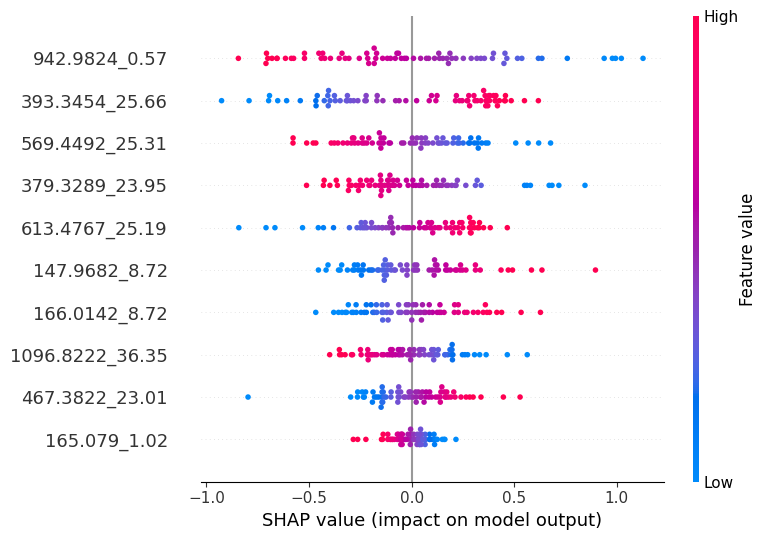

In [ ]:
fesel.plot_shap_values(plot_type='summary',label=1)

In [ ]:
import shap

**χερατα**

In [ ]:
from dash import Dash, dcc, html, Input, Output
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
import ipywidgets as widgets

app = Dash(__name__)

app.layout = html.Div([
    html.H4("Visualization of PCA's explained variance"),
    dcc.Graph(id="graph"),
    html.P("Number of components:"),
    dcc.Slider(
        id='slider',
        min=2, max=5, value=3, step=1)
])

@app.callback(
    Output("graph", "figure"), 
    Input("slider", "value"))
def run_and_plot(n_components):
    try:
        pca = PCA(n_components=n_components)
        components = pca.fit_transform(fesel.X)

        var = pca.explained_variance_ratio_.sum() * 100
        labels = {i: f'PC{i+1}' for i in range(n_components)}

        fig = px.scatter_matrix(
            components,
            color=fesel.y,
            dimensions=range(n_components),
            labels=labels,
            title=f'Total Explained Variance: {var:.2f}%')
        fig.update_traces(diagonal_visible=False)
        return fig
    except Exception as e:
        return px.scatter_matrix(title=f'An error occurred: {e}')

app.run_server(debug=True)

In [ ]:
def create_pca_dataframe(X, n_components):
    """
    Performs PCA on the given dataset X and returns a DataFrame with the principal components.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The input data to perform PCA on.
    - n_components: int
        The number of principal components to compute.

    Returns:
    - df_pca: pandas.DataFrame
        DataFrame containing the principal components.
    """
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X)
    component_names = [f'PC{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(components, columns=component_names)
    return df_pca

df_pca = create_pca_dataframe(fesel.X, 2)

# mean_shap_values = abs(fesel.shap_values.values).mean(axis=0)

# fig = make_subplots(rows=1, cols=2, subplot_titles=('PCA Plot', 'SHAP Values'),
#                     specs=[[{'type': 'scatter'}, {'type': 'bar'}]])

# scatter = go.Scatter(x=df_pca['PC1'], y=df_pca['PC2'], mode='markers', name='Data Points',
#                      marker=dict(color=fesel.y, colorscale='Viridis', showscale=True))

# bar = go.Bar(x=[f'Feature {i}' for i in range(len(mean_shap_values))], y=mean_shap_values)

# fig.add_trace(scatter, row=1, col=1)
# fig.add_trace(bar, row=1, col=2)

# fig.update_layout(showlegend=False, width=1000, height=500, clickmode='event+select')

# fig_widget = go.FigureWidget(fig)

# def update_shap_plot(trace, points, state):
#     if points.point_inds:
#         idx = points.point_inds[0]  
#         shap_values_point = fesel.shap_values.values[idx]  
#         with fig_widget.batch_update():
#             fig_widget.data[1].y = shap_values_point

# fig_widget.data[0].on_click(update_shap_plot)
# display(fig_widget)


In [ ]:
def create_interactive_pca_shap_plot(df_pca, X, components, image_size=(1000, 500),top_n_features=20):
    """
    Creates an interactive plot with PCA on one side and SHAP values on the other.

    Parameters:
    - df_pca: DataFrame containing PCA components.
    - X: The original dataset used for PCA and SHAP value calculation.
    - components: Tuple of indices for the PCA components to plot, e.g., (0, 1) for PC1 vs. PC2.
    - image_size: Tuple for the image size, default to (1000, 500).

    Returns:
    - A Plotly FigureWidget with interactive capabilities in a Jupyter environment.
    """
    pc_x, pc_y = f'PC{components[0]+1}', f'PC{components[1]+1}'
    
    mean_shap_values = abs(fesel.shap_values.values).mean(axis=0)
    top_indices = mean_shap_values.argsort()[-top_n_features:][::-1]  # Indices of top features
    top_mean_shap_values = mean_shap_values[top_indices]

    fig = make_subplots(rows=1, cols=2, subplot_titles=('PCA Plot', 'SHAP Values'),
                        specs=[[{'type': 'scatter'}, {'type': 'bar'}]],
                        horizontal_spacing=0.1)
    
    scatter = go.Scatter(x=df_pca[pc_x], y=df_pca[pc_y], mode='markers', name='Data Points',
                         marker=dict(color=fesel.y, colorscale='Viridis', showscale=True))
    fig.add_trace(scatter, row=1, col=1)

    bar = go.Bar(x=[f'Feature {i}' for i in top_indices], y=top_mean_shap_values)
    fig.add_trace(bar, row=1, col=2)

    fig.update_layout(showlegend=False, width=image_size[0], height=image_size[1], clickmode='event+select')

    # Convert to FigureWidget for interactivity in Jupyter
    fig_widget = go.FigureWidget(fig)

    # Define callback function for updates
    def update_shap_plot(trace, points, selector):
        if points.point_inds:
            idx = points.point_inds[0]  
            shap_values_point = fesel.shap_values.values[idx][top_indices]  
            with fig_widget.batch_update():
                fig_widget.data[1].y = shap_values_point

    fig_widget.data[0].on_click(update_shap_plot)

    return fig_widget

In [ ]:
create_interactive_pca_shap_plot(df_pca, fesel.X, (0, 1), image_size=(1200, 800),top_n_features=30)

FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888888,
                                        '#b5de2b'], [1.0,

In [ ]:
#eisai enas megalos malakas kai megalos shap values kai megalos PCA plot kai megalos summary plot kai megalos beeswarm plot